# Projeto de Aprendizado de Máquina para Detecção de Pneumonia com Python/Machine Learning Project for Pneumonia Detection with Python
## Utilizando a Biblioteca Fastai/Using the Fastai Library


Projeto de Machine Learning para a detecção de pneumonia, utilizando a linguagem de programação Python e a biblioteca Fastai./Machine Learning project for pneumonia detection, using the Python programming language and the Fastai library.
![download](https://github.com/GabrielleMarchioli/Aprendizado-de-M-quina-para-Detec-o-de-Pneumonia-com-Python/assets/109180231/f4fa9413-abc4-44b2-bc1a-549cf195a9a3)
<br>
feito por: Gabrielle Marchioli/
made by: Gabrielle Marchioli

# Bibliotecas usadas/Libraries used:


In [2]:

import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from google.colab import files

#Importando o dataset/Importing the dataset:

In [3]:
from google.colab import files

!pip install -U -q kaggle
!mkdir /root/.kaggle

files.upload()
!cp kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


mkdir: cannot create directory ‘/root/.kaggle’: File exists


Saving kaggle.json to kaggle (4).json
 99% 2.27G/2.29G [00:19<00:00, 216MB/s]
100% 2.29G/2.29G [00:19<00:00, 127MB/s]


#Importing the dataset/Importing the dataset:

In [4]:
import os

# instala a ferramenta pv, que é um utilitário para exibir o progresso de dados através de um pipeline./installs the pv tool, which is a utility for displaying data progress through a pipeline.
!apt install pv
!unzip -o /content/chest-xray-pneumonia.zip | pv -l >/dev/null
#O pv -l está sendo usado para exibir o progresso da extração./pv -l is being used to display the extraction progress.
#O >/dev/null redireciona a saída para o null para evitar a exibição na tela./>/dev/null redirects output to null to avoid displaying it on the screen.
os.remove('chest-xray-pneumonia.zip')




Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pv is already the newest version (1.6.6-1build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
17.6k 0:00:29 [ 605 /s] [                              <=>                     ]


# Fazendo o Modelo/Make Model:

In [5]:
base_model=MobileNet(weights='imagenet',include_top=False) #importa o modelo mobilenet e descarta a última camada de 1.000 neurônios./imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #adicionamos camadas densas para que o modelo possa aprender funções mais complexas e classificar para obter melhores resultados./we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #camada final com ativação softmax./final layer with softmax activation.


In [6]:
#criaçao de um novo modelo combinando a MobileNet com as camadas adicionais./creation of a new model combining MobileNet with additional layers.
model = Model(inputs=base_model.input, outputs=preds)

#congelar as 20 primeiras camadas para não serem treinadas novamente./freeze the first 20 layers so they cannot be trained again.
for layer in model.layers[:20]:
  layer.trainable = False

#Descongelar as camadas apos a vigésima para serem treinadas./Thaw the layers after the twentieth to be trained.
for layer in model.layers[20:]:
  layer.trainable = True

#Treinando o modelo/Training the model:

In [7]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory('/content/chest_xray/test/',
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    batch_size=32,
                                                    class_mode='categorical', shuffle=True)
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=5)

Found 624 images belonging to 2 classes.


<ipython-input-7-bb33dd9d2cfd>:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,


Epoch 1/5
19/19 [==============================] - 56s 3s/step - loss: 0.5273 - accuracy: 0.8378
Epoch 2/5
19/19 [==============================] - 46s 2s/step - loss: 0.0673 - accuracy: 0.9780
Epoch 3/5
19/19 [==============================] - 46s 2s/step - loss: 0.0703 - accuracy: 0.9797
Epoch 4/5
19/19 [==============================] - 45s 2s/step - loss: 0.0569 - accuracy: 0.9797
Epoch 5/5
19/19 [==============================] - 46s 2s/step - loss: 0.0271 - accuracy: 0.9865


In [8]:
#Salvar os pesos/Save the weights:
model.save('chest-xray-pneumonia.h5') #o método save do Keras é usado para salvar todo o modelo, incluindo a arquitetura, configuração e os pesos, em um arquivo H5./The Keras save method is used to save the entire model, including the architecture, configuration and weights, into an H5 file.
!zip -r model.zip 'chest-xray-pneumonia.h5' #compacta o modelo./compact the model.



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


updating: chest-xray-pneumonia.h5 (deflated 9%)


#Implementação/Implementation:

In [9]:
from keras.models import load_model
new_model = load_model("/content/chest-xray-pneumonia.h5")

def get_rez(pic):
  img = image.load_img(pic, target_size=(224,224))
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  p_good,p_ill = np.around(new_model.predict(x), decimals=2)[0]
  return{'p_good' :p_good, 'p_ill' :p_ill}

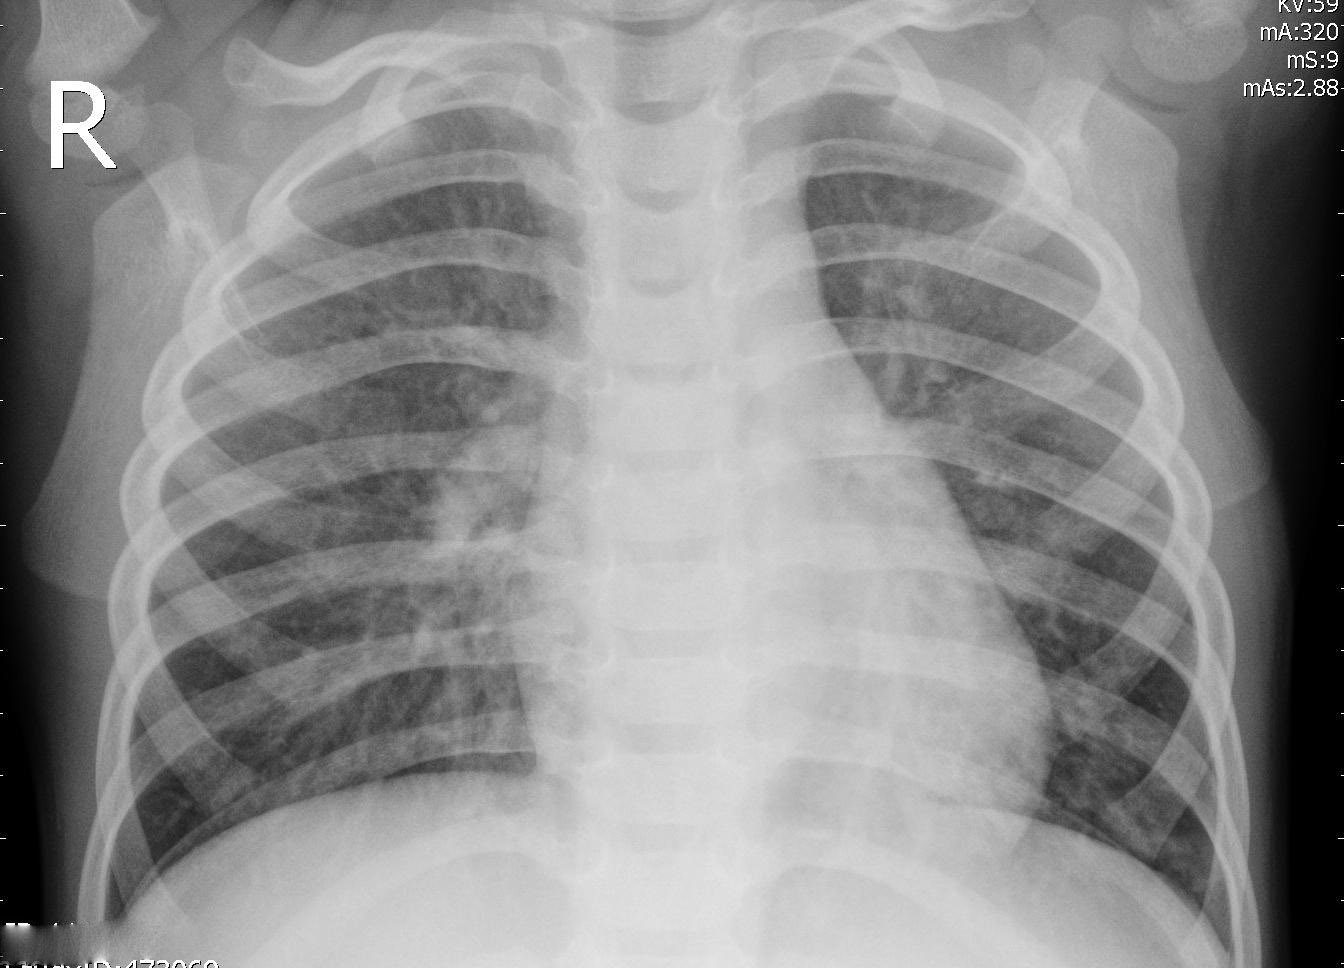

1/1 [==============================] - 0s 117ms/step
Predição para /content/chest_xray/test/PNEUMONIA/person1626_virus_2818.jpeg:
 - Pneumonia: 100.00%
 - Normal: 0.00%



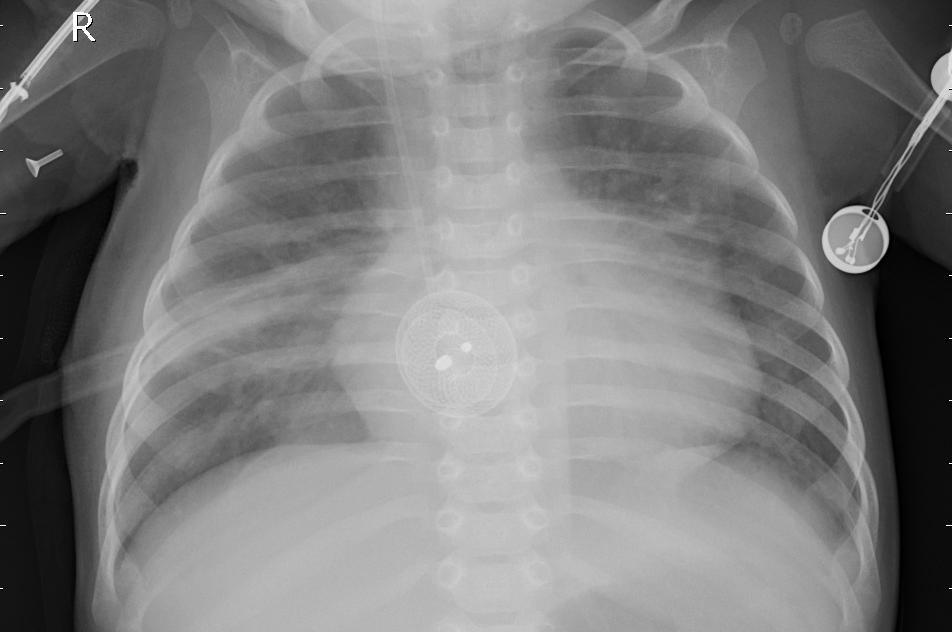

1/1 [==============================] - 0s 71ms/step
Predição para /content/chest_xray/test/PNEUMONIA/person85_bacteria_421.jpeg:
 - Pneumonia: 100.00%
 - Normal: 0.00%



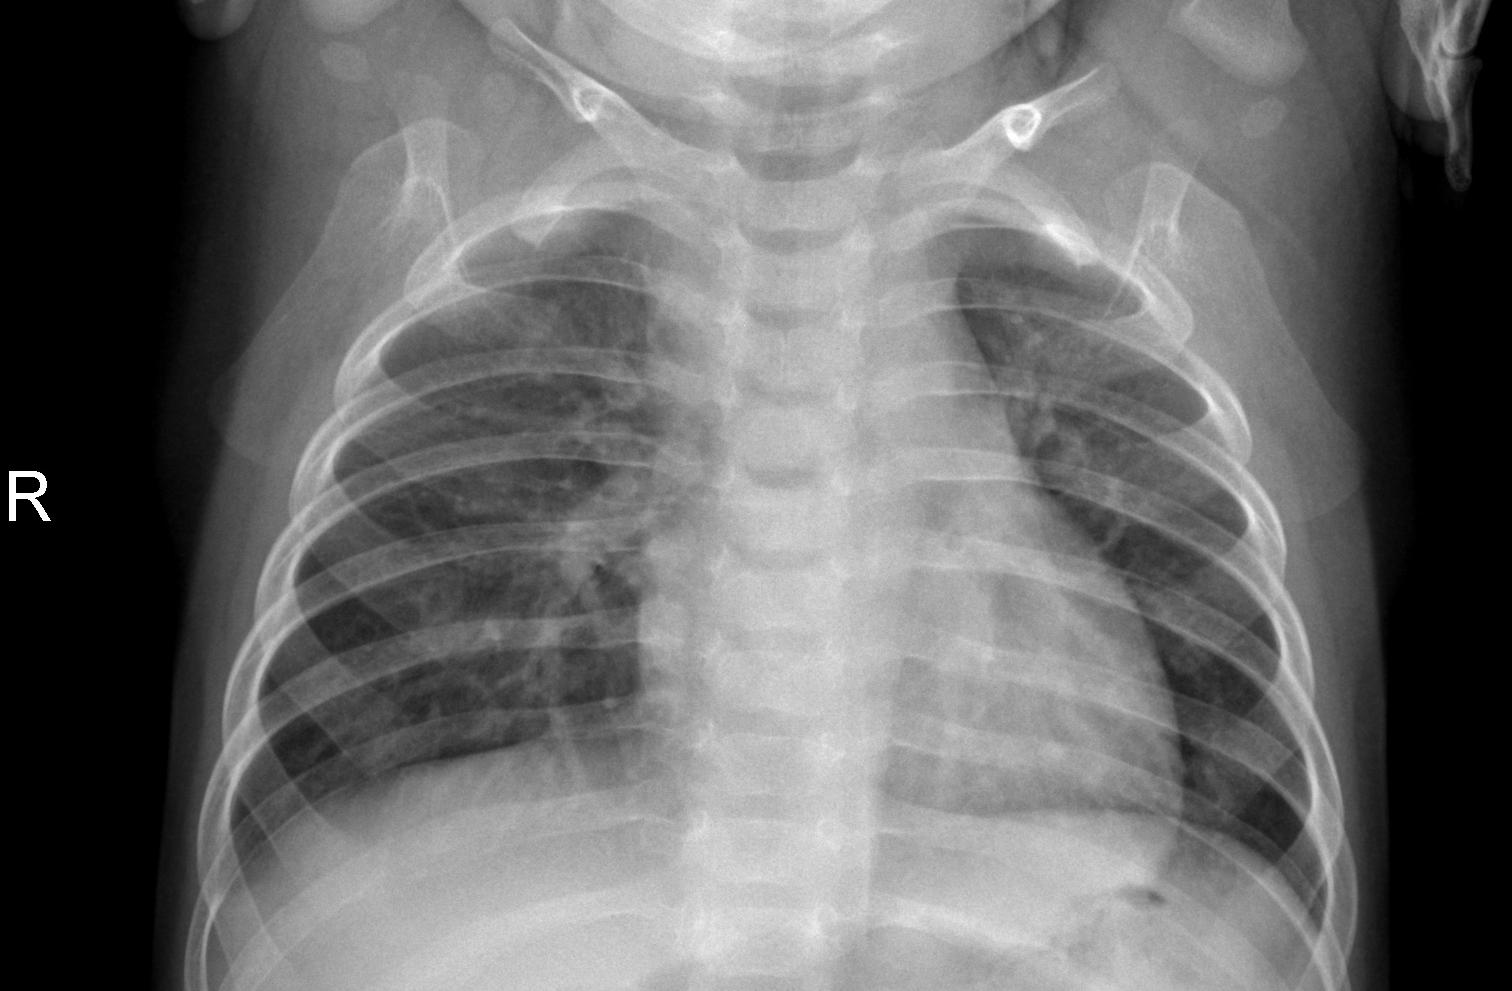

1/1 [==============================] - 0s 112ms/step
Predição para /content/chest_xray/test/PNEUMONIA/person88_bacteria_439.jpeg:
 - Pneumonia: 100.00%
 - Normal: 0.00%



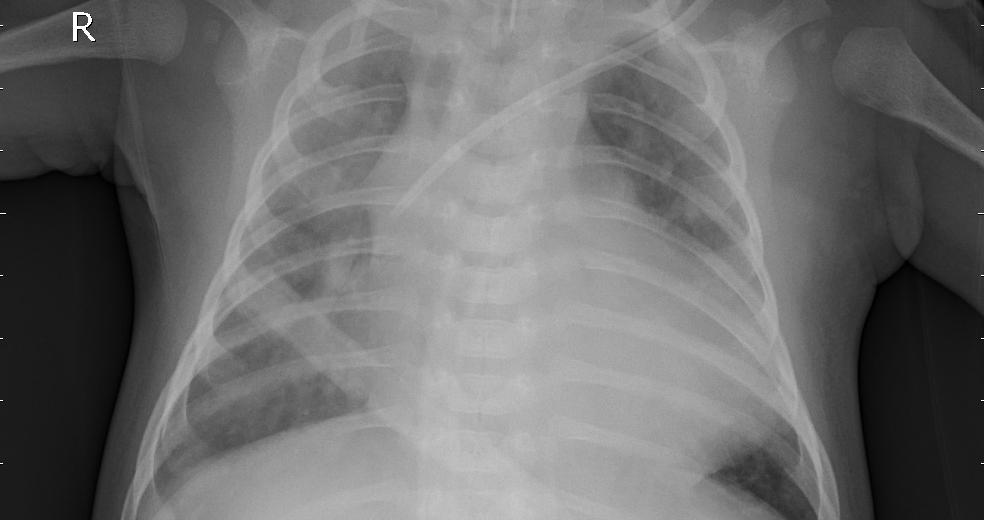

1/1 [==============================] - 0s 86ms/step
Predição para /content/chest_xray/test/PNEUMONIA/person122_bacteria_582.jpeg:
 - Pneumonia: 100.00%
 - Normal: 0.00%



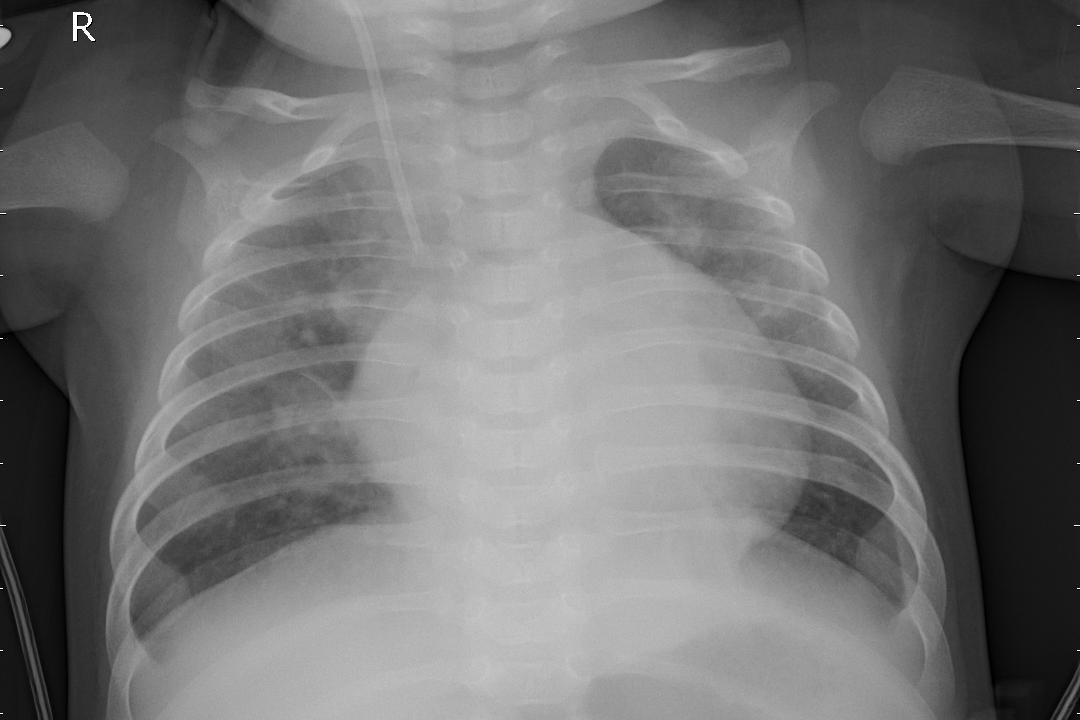

1/1 [==============================] - 0s 108ms/step
Predição para /content/chest_xray/test/PNEUMONIA/person130_bacteria_627.jpeg:
 - Pneumonia: 100.00%
 - Normal: 0.00%



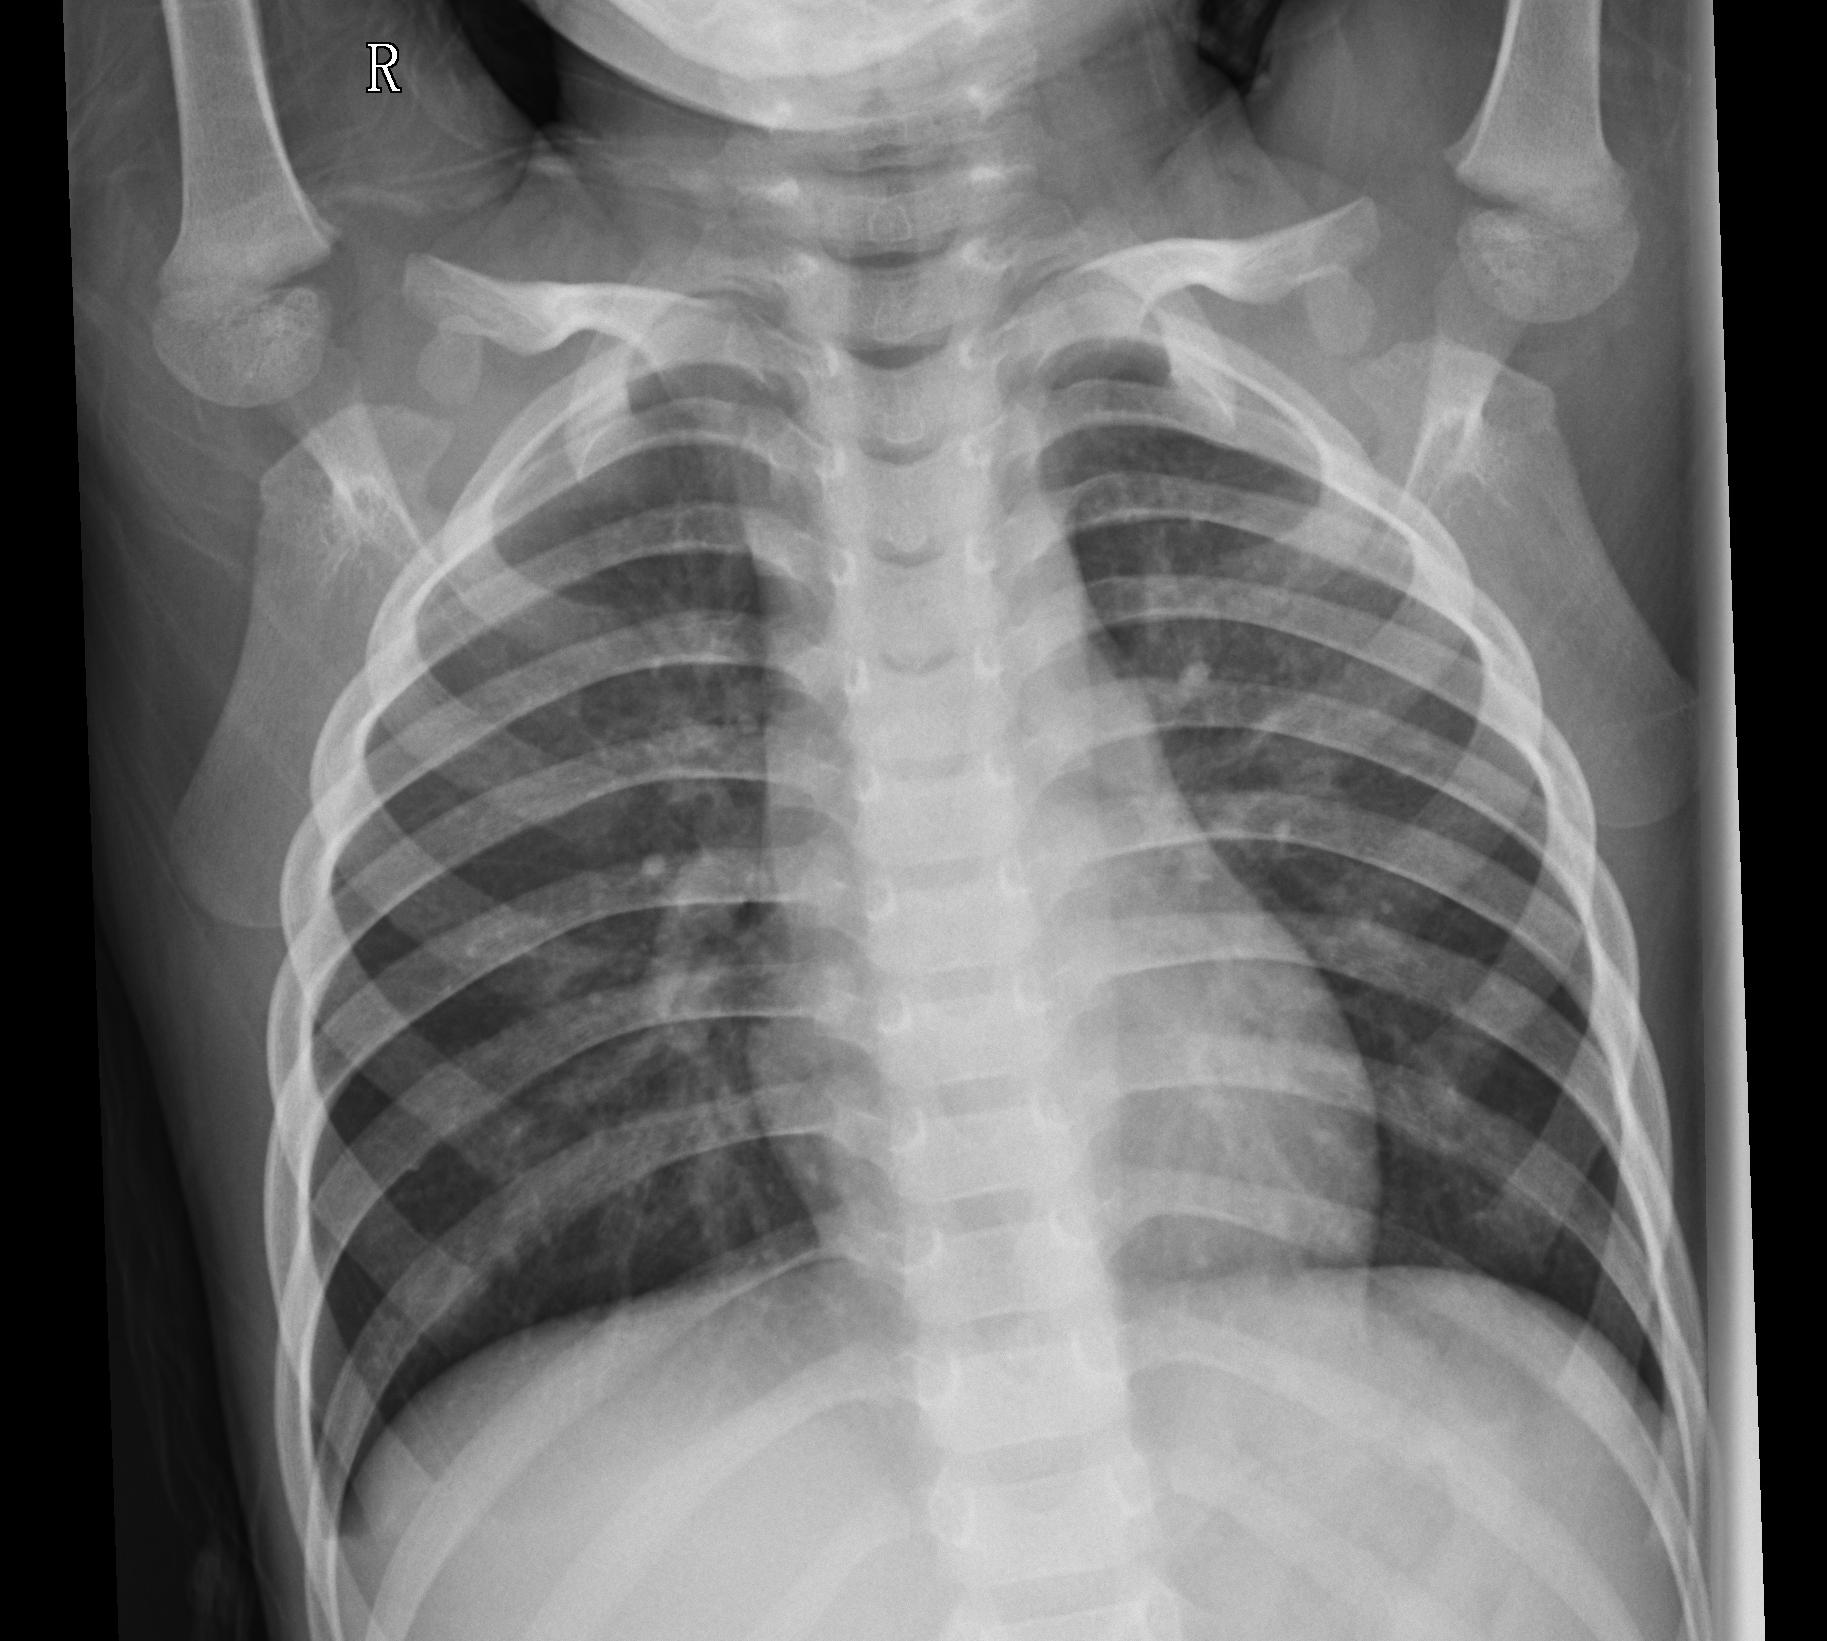

1/1 [==============================] - 0s 121ms/step
Predição para /content/chest_xray/test/NORMAL/NORMAL2-IM-0130-0001.jpeg:
 - Pneumonia: 0.00%
 - Normal: 100.00%



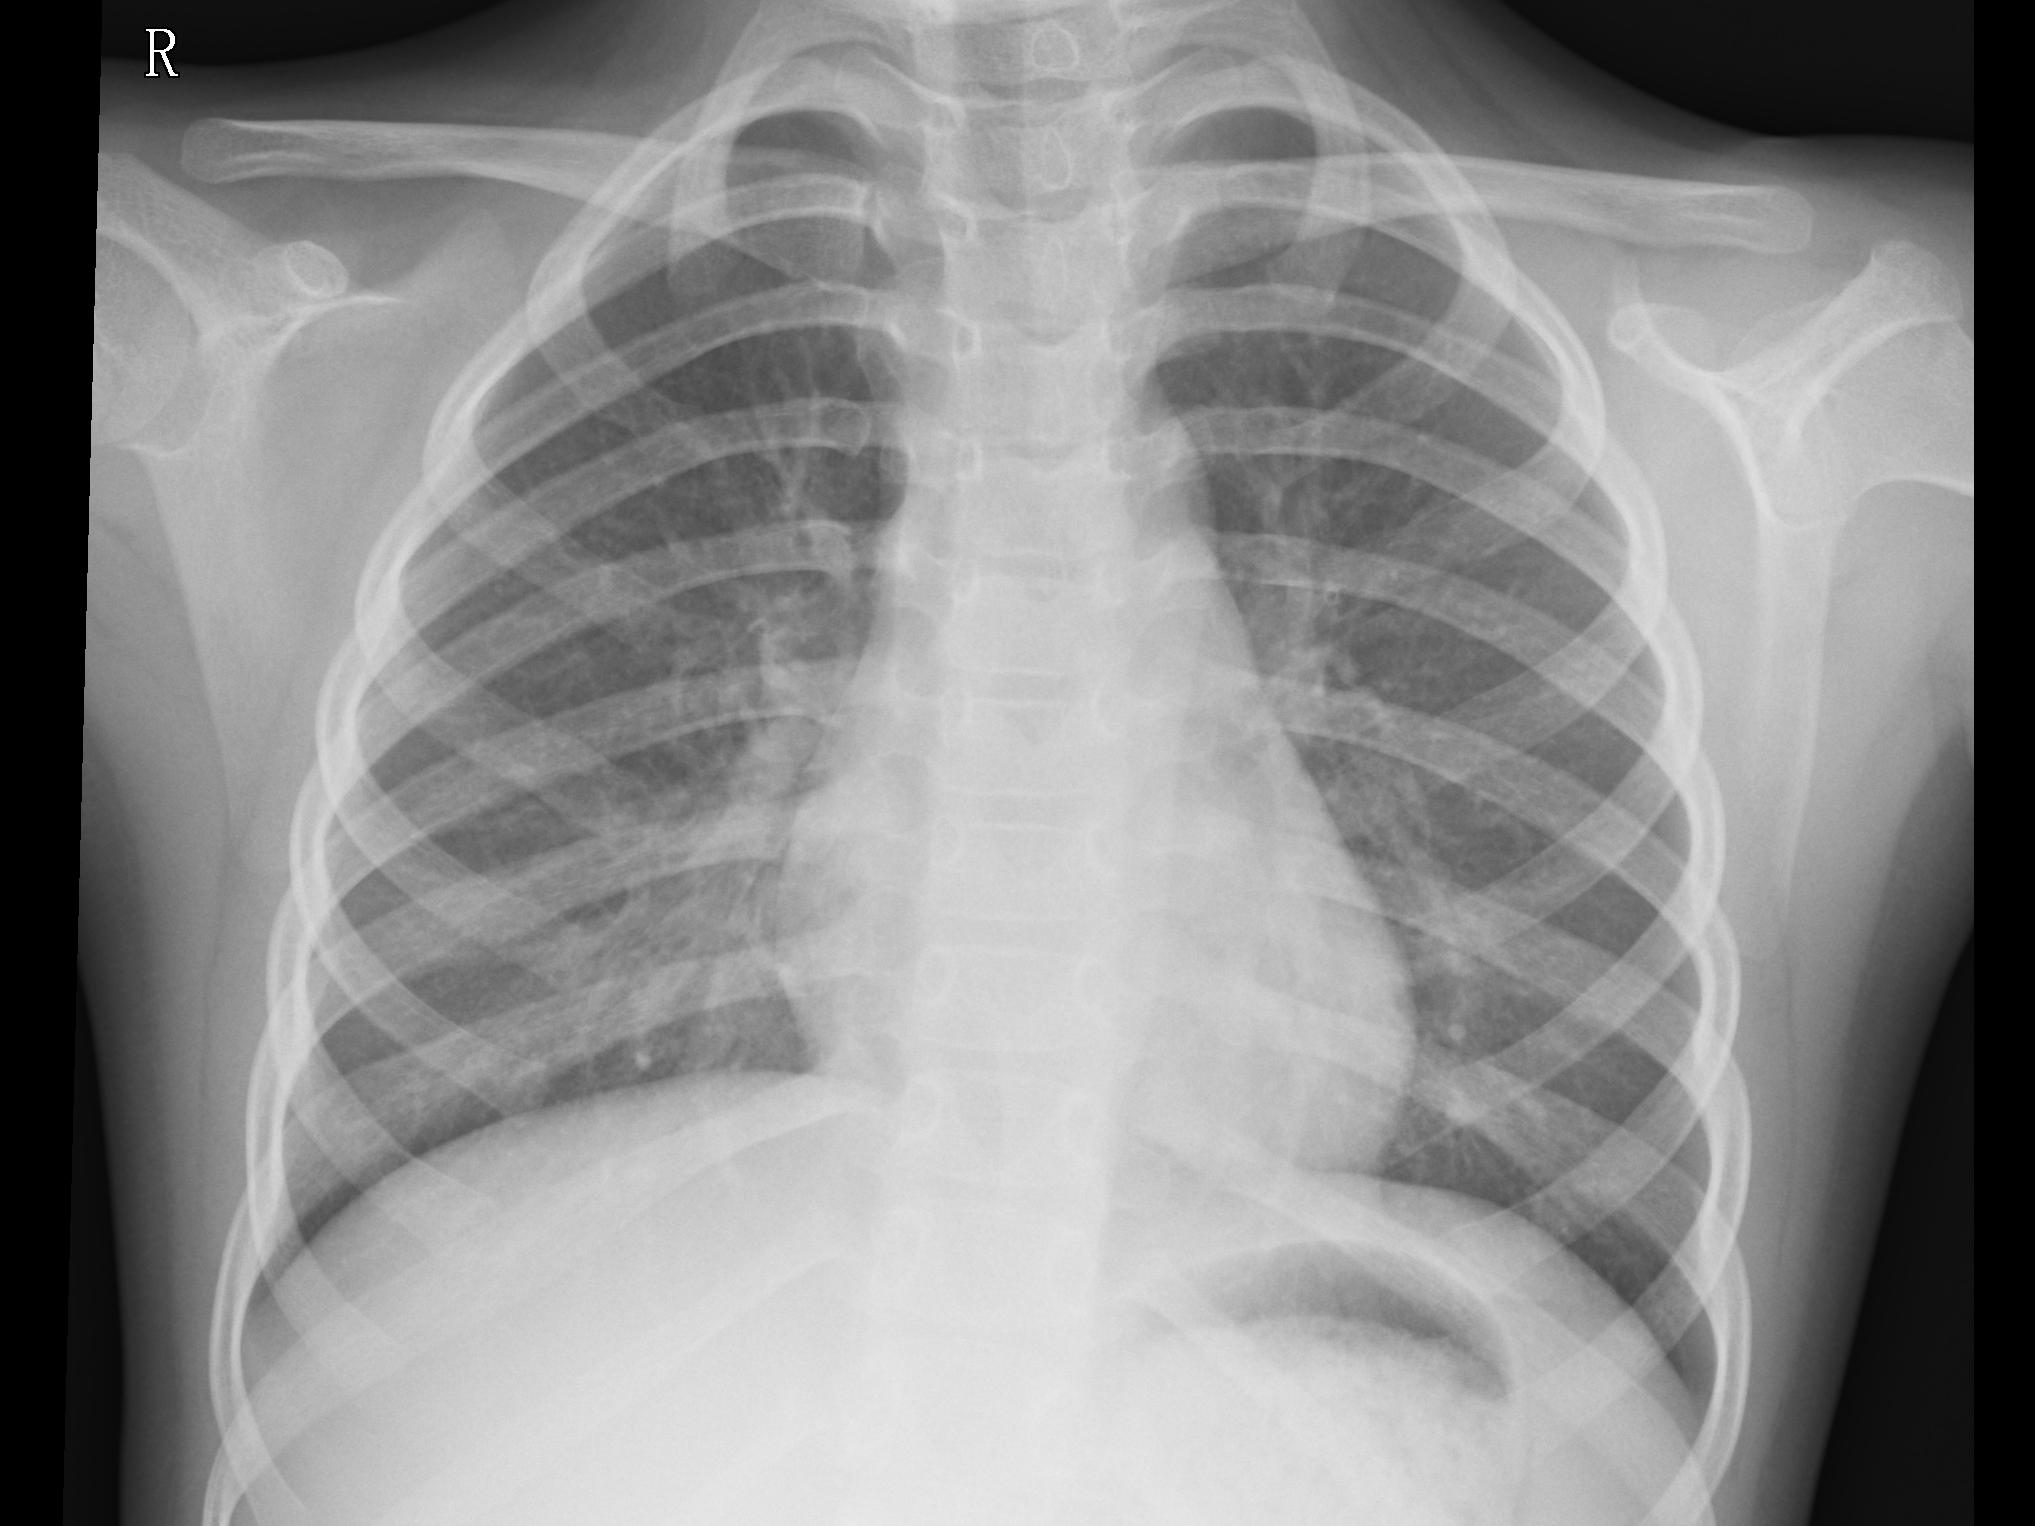

1/1 [==============================] - 0s 72ms/step
Predição para /content/chest_xray/test/NORMAL/NORMAL2-IM-0111-0001.jpeg:
 - Pneumonia: 0.00%
 - Normal: 100.00%



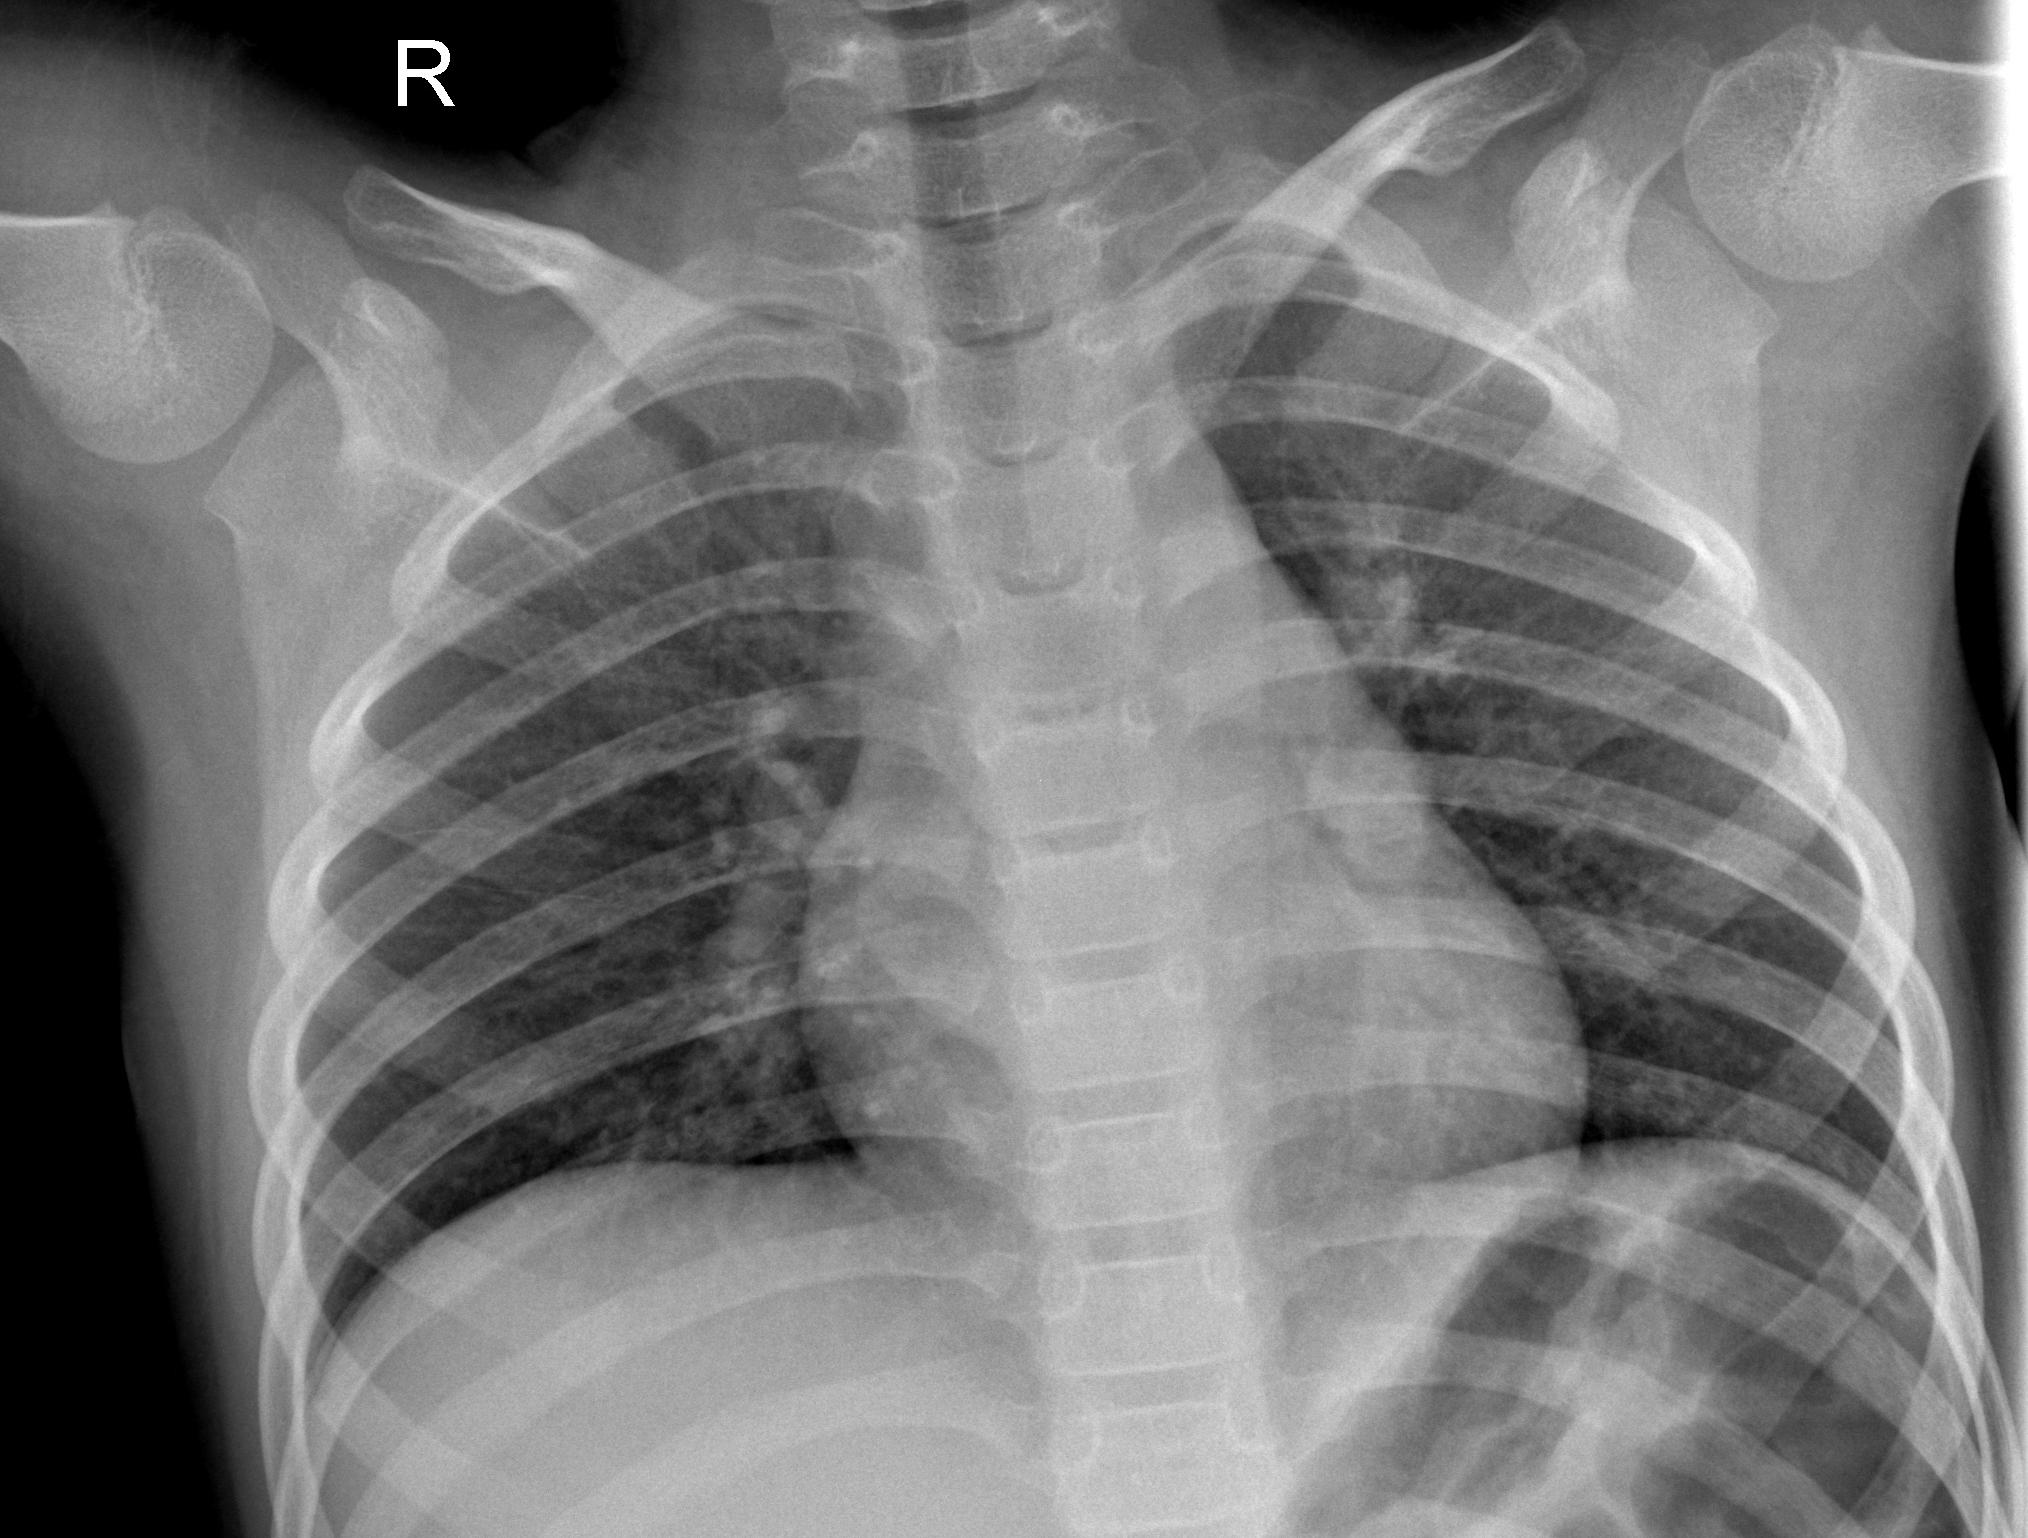

1/1 [==============================] - 0s 79ms/step
Predição para /content/chest_xray/test/NORMAL/NORMAL2-IM-0312-0001.jpeg:
 - Pneumonia: 0.01%
 - Normal: 99.99%



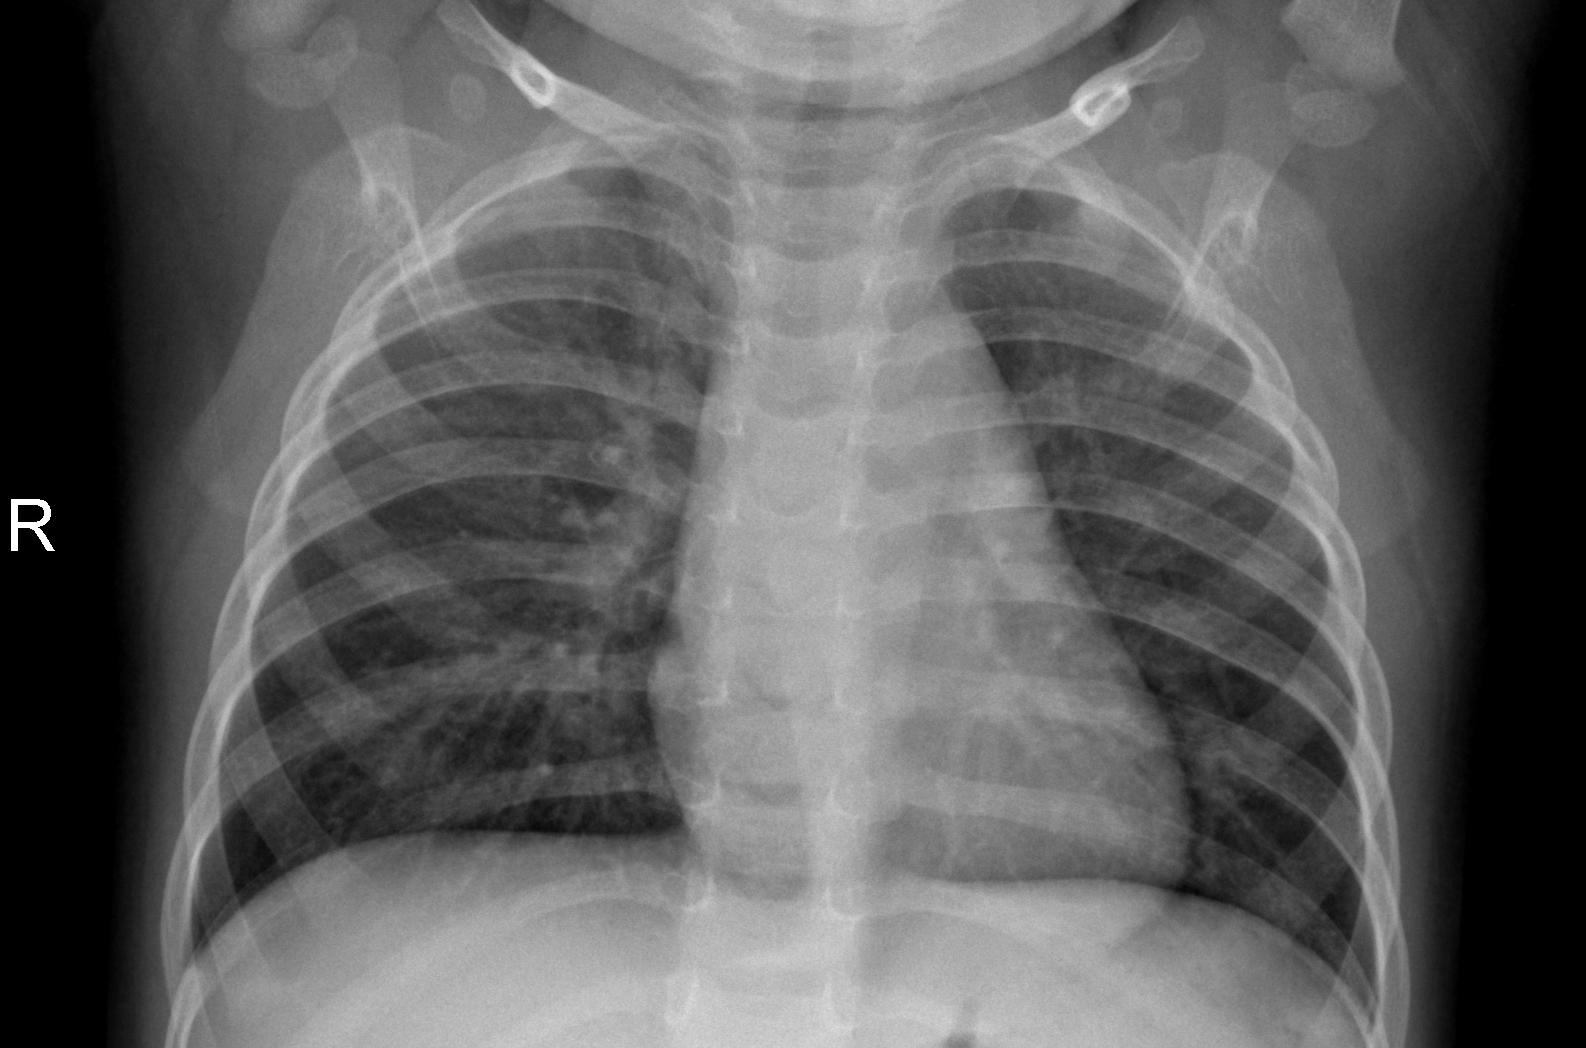

1/1 [==============================] - 0s 50ms/step
Predição para /content/chest_xray/test/NORMAL/NORMAL2-IM-0378-0001.jpeg:
 - Pneumonia: 0.04%
 - Normal: 99.96%



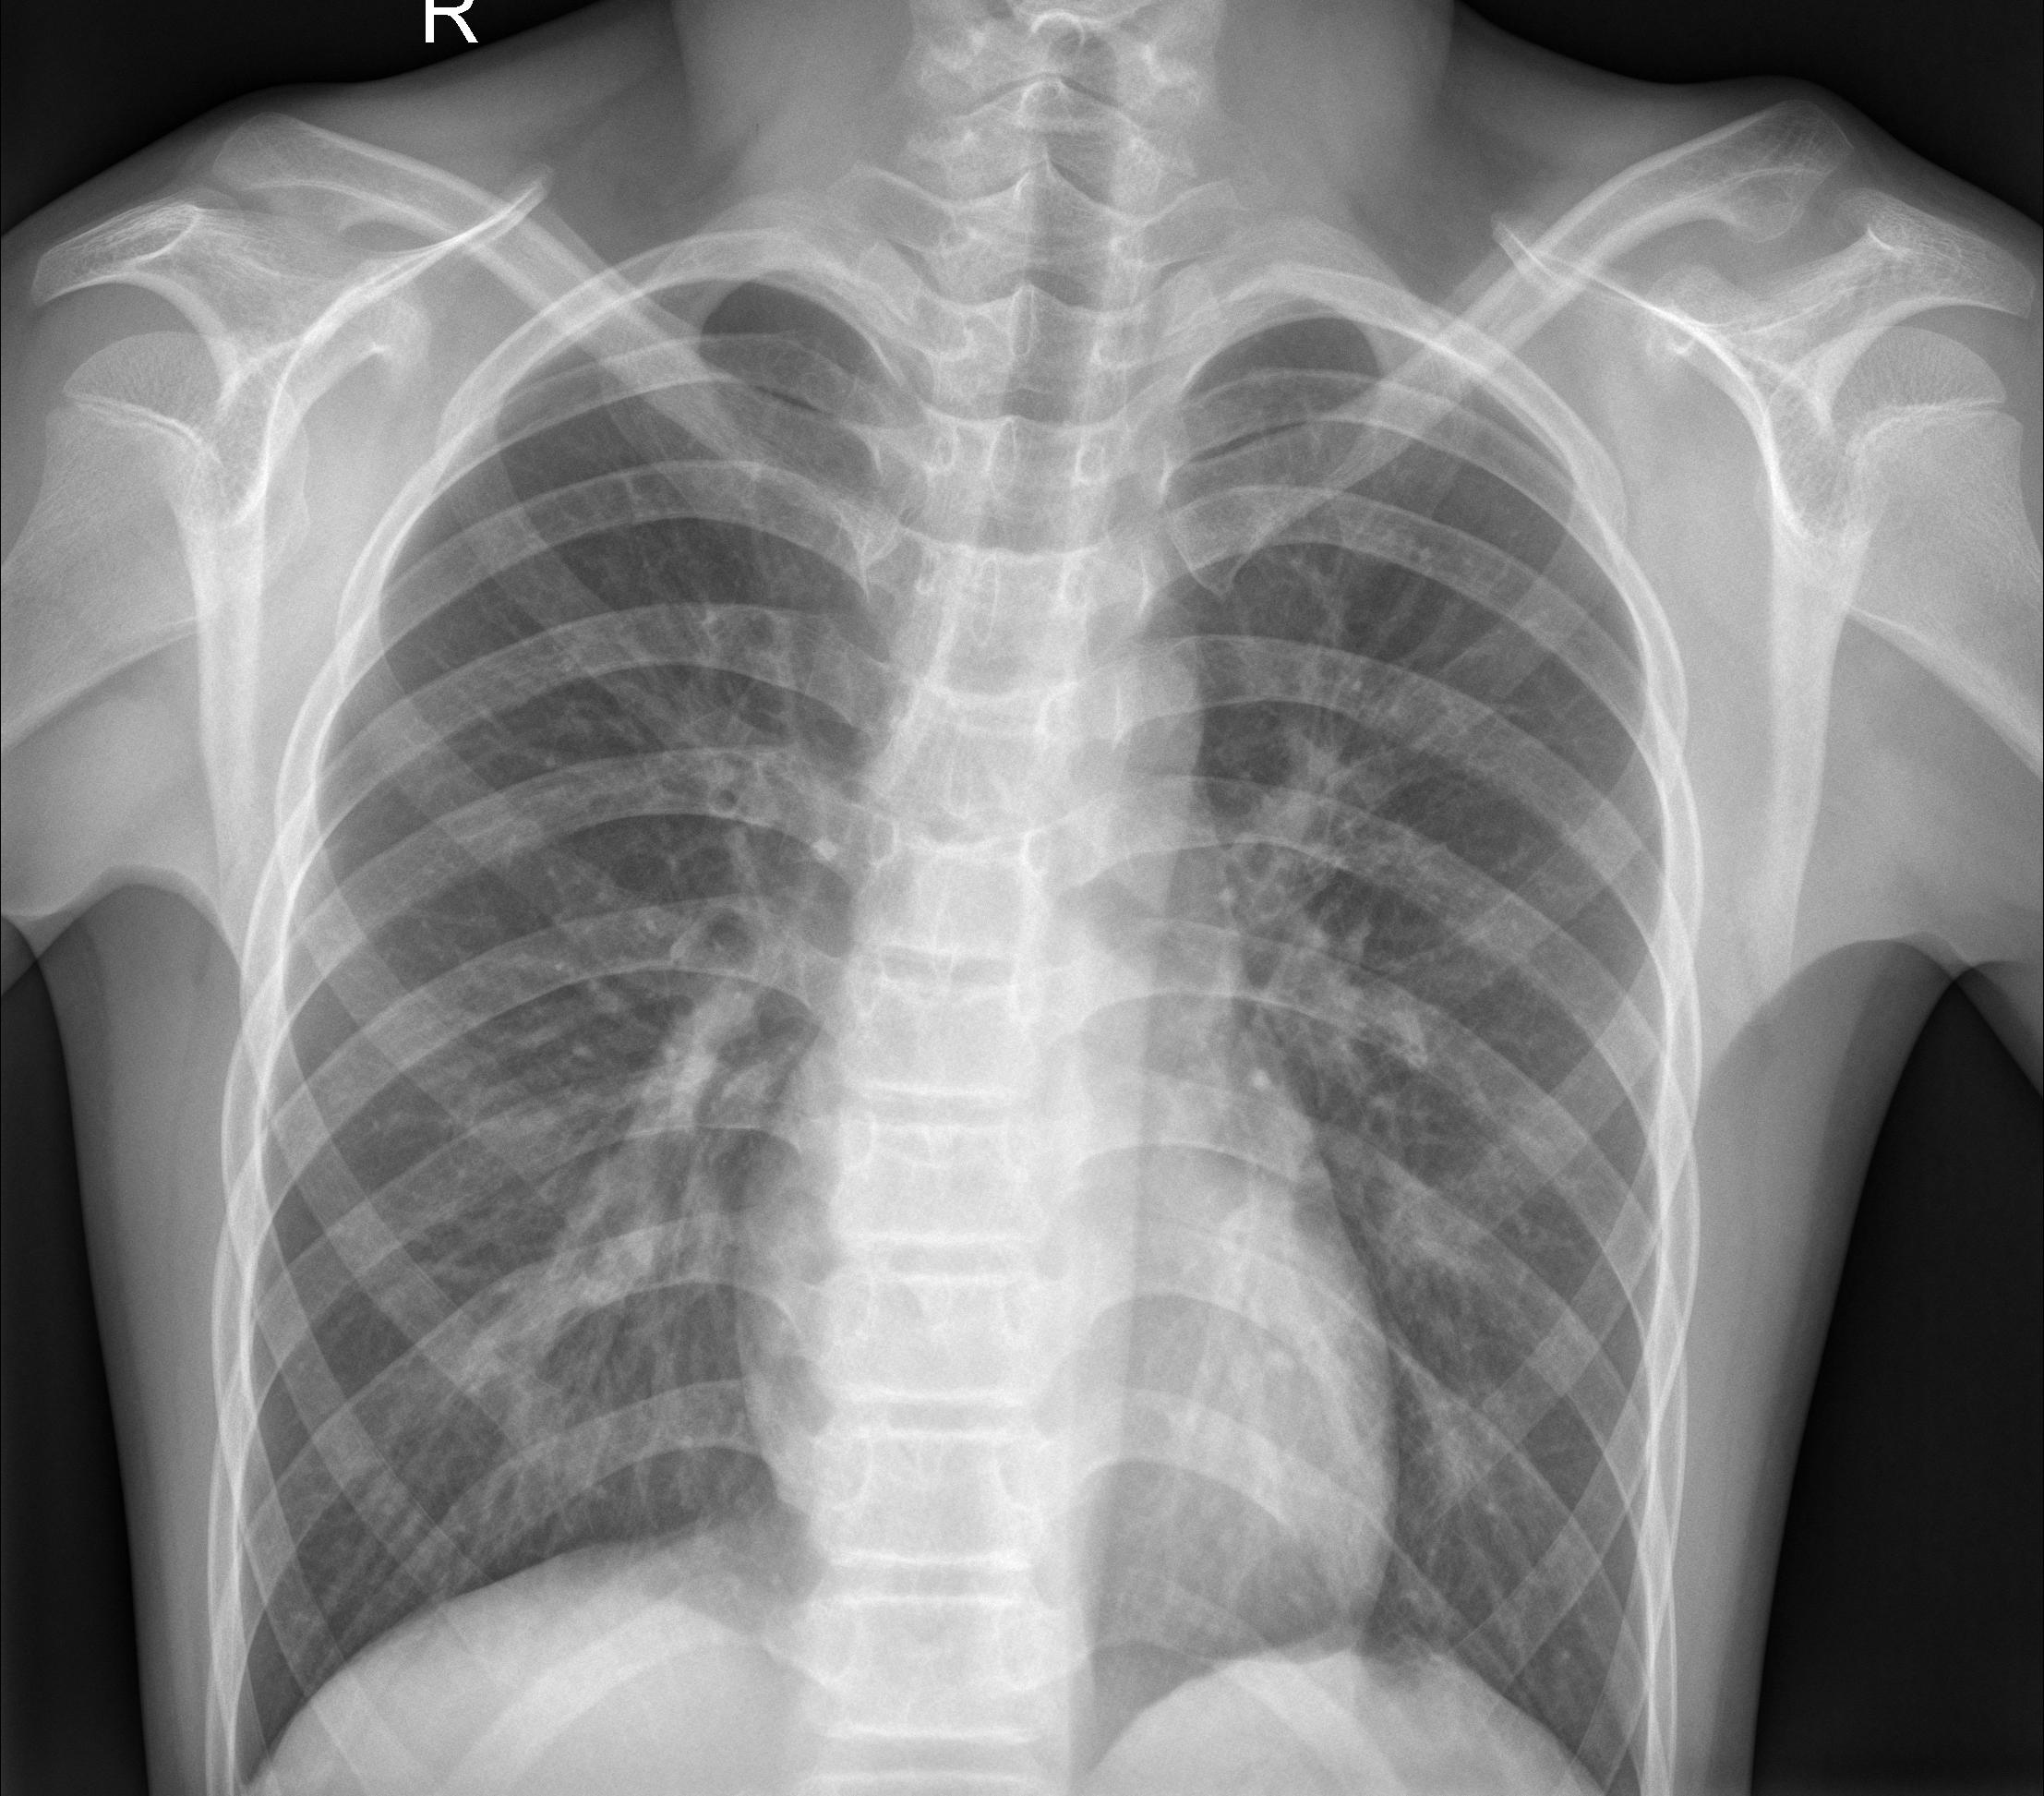

1/1 [==============================] - 0s 58ms/step
Predição para /content/chest_xray/test/NORMAL/IM-0011-0001-0002.jpeg:
 - Pneumonia: 0.00%
 - Normal: 100.00%



In [11]:
from IPython.display import Image, display
# Carregando a imagem e realizando pré-processamento./Loading the image and performing preprocessing.
def get_rez(pic):
    img = image.load_img(pic, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Fazendo previsões usando o modelo./Making predictions using the model.
    predictions = new_model.predict(x)
    p_good, p_ill = predictions[0]

     # Retornando um dicionário com as previsões e as probabilidades associadas./Returning a dictionary with the predictions and associated probabilities.
    return {'p_good': p_good, 'p_ill': p_ill, 'probabilities': predictions}

# Diretórios das imagens de teste./Test image directories.
ill_path = "/content/chest_xray/test/PNEUMONIA/"
good_path = "/content/chest_xray/test/NORMAL/"

# Lista das primeiras 5 imagens em cada diretório./List of the first 5 images in each directory.
ill_images = [ill_path + img for img in os.listdir(ill_path)[:5]]
good_images = [good_path + img for img in os.listdir(good_path)[:5]]

# Exibe e analisa as previsões para imagens com pneumonia./Display and analyze predictions for images with pneumonia.
for ill_pic in ill_images:
    display(Image(filename=ill_pic, width=224, height=224))
    predictions = get_rez(ill_pic)
    print(f"Predição para {ill_pic}:")
    print(f" - Pneumonia: {predictions['p_ill']:.2%}")
    print(f" - Normal: {predictions['p_good']:.2%}")
    print("")

# Exibe e analisa as previsões para imagens sem pneumonia./Displays and analyzes predictions for pneumonia-free images.
for good_pic in good_images:
    display(Image(filename=good_pic, width=224, height=224))
    predictions = get_rez(good_pic)
    print(f"Predição para {good_pic}:")
    print(f" - Pneumonia: {predictions['p_ill']:.2%}")
    print(f" - Normal: {predictions['p_good']:.2%}")
    print("")